In [1]:
import numpy 
from math import * 
from scipy import integrate
from matplotlib import pyplot 

In [2]:
# defines the cylinder
R = 1.0                                                           # radius
theta = numpy.linspace(0, 2*pi, 100)                         # angles in radians
x_cylinder, y_cylinder = R*numpy.cos(theta), R*numpy.sin(theta)   # coordinates of the cylinder

%matplotlib inline

In [3]:
#transforming into Joukowsky 
 
N_panels = 10
T  = 0.1
c = 1 
H = 0.0
a = c/4
theta = numpy.linspace(0, 2*pi, N_panels+1) 
Zeta_c = -4*a/(3*sqrt(3))*T+1j*2*H
r_s = ((1/4)+(T/(3*sqrt(3))))*c
 
Zeta = (r_s)*numpy.exp(1j*(theta))

J = (Zeta+Zeta_c) + a**2/(Zeta+Zeta_c)

xm = J.real
ym = J.imag

#xm = xm[::-1]
#ym = ym[::-1]




In [4]:
#Flap
Nfpanels = 10
T  = 0.1
c = 0.2 
H = 0.00
a = c/4
theta = numpy.linspace(0, 2*pi, Nfpanels+1) 
Zeta_c = -4*a/(3*sqrt(3))*T+1j*2*H
r_s = ((1/4)+(T/(3*sqrt(3))))*c
 
Zeta = (r_s)*numpy.exp(1j*(theta))

Jf = (Zeta+Zeta_c) + a**2/(Zeta+Zeta_c)

xf = Jf.real+0.6
yf = Jf.imag-0.05



(-0.60000000000000009,
 0.80000000000000004,
 -0.059999999999999998,
 0.059999999999999998)

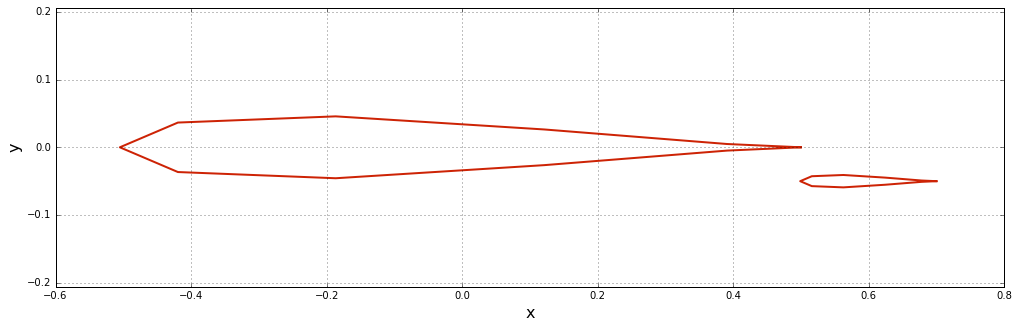

In [5]:
# #transforming into Joukowsky 
pyplot.figure(figsize=(17,5))

pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)

pyplot.plot(xm, ym, color='#CD2305', linestyle='-', linewidth=2)
pyplot.plot(xf, yf, color='#CD2305', linestyle='-', linewidth=2)
pyplot.axis("equal")


In [6]:
class Panel:

    def __init__(self, xa, ya, xb, yb):

        # End Points
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        # Center Point
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       
        
        # Length
        self.length = sqrt((xb-xa)**2+(yb-ya)**2)
        
        # Orientation
        if xb-xa <= 0.:
            self.beta = acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = pi + acos(-(yb-ya)/self.length)
                
                               
        # Normal and Tangental Coponents
        self.n= [ cos(self.beta), sin(self.beta)]
        self.t= [-sin(self.beta), cos(self.beta)] 
        
        # Strength  
        self.kappa = 1.0 
        
        # Pressure Coeffecient          
        self.cp = 0.
        
        # Tangent Velocity      
        self.vt = 0.

In [7]:
# Define panels for main foil

panels = numpy.empty(N_panels+1, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(xm[i], ym[i], xm[i+1], ym[i+1])
panels[-1] = Panel(xm[0], ym[0], xm[0]+1000, ym[0])

# Define panels for air foil

panelsf = numpy.empty(Nfpanels+1, dtype=object)
for i in range(Nfpanels):
    panelsf[i] = Panel(xf[i], yf[i], xf[i+1], yf[i+1])
panelsf[-1] = Panel(xf[0], yf[0], xf[0]+1000, yf[0])


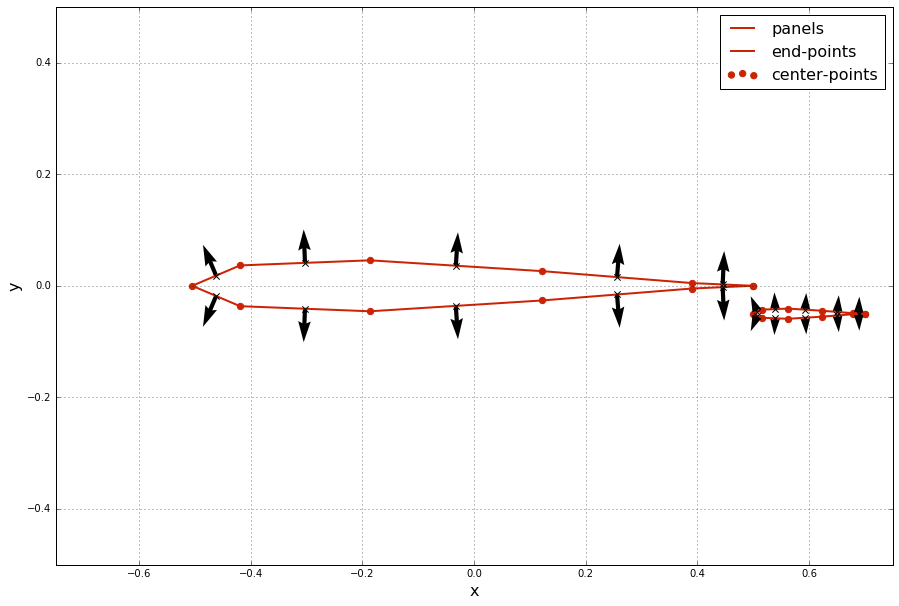

In [8]:
# plot the panels
#size = 6
pyplot.figure(figsize=(15, 10))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(xm, ym, color='#CD2305', linestyle='-', linewidth=2)
pyplot.plot(xf, yf, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=25, width=0.005)

pyplot.scatter([p.xa for p in panelsf], [p.ya for p in panelsf], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panelsf], [p.yc for p in panelsf], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panelsf], [p.yc for p in panelsf], [p.n[0] for p in panelsf], [p.n[1] for p in panelsf],
              scale=50, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], loc='best', prop={'size':16})
pyplot.xlim(-0.75, 0.75)
pyplot.ylim(-0.5, 0.5);

In [9]:
Uinf = 1.0                    # free-stream velocity
alpha = 2.0*pi/180            # angle of attack

In [10]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  sin(p.beta)*(x-p.xb) - cos(p.beta)*(y-p.yb)
    y_p =  cos(p.beta)*(x-p.xb) + sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  sin(p.beta)*u_p + cos(p.beta)*v_p
    v = -cos(p.beta)*u_p + sin(p.beta)*v_p
    
    return u, v

In [11]:
Nt = numpy.concatenate((panels,panelsf))
No = 2*(N_panels+1)
print (No)

22


In [12]:
# compute the influence coefficient matrix
def source_matrix(Nt):
    A = numpy.zeros((No, No), dtype=float)
    for i, p_i in enumerate(Nt[0:No]):
        for j, p_j in enumerate(Nt):
            A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
            if i == j:
                A[i,j] *= 1.001
    
    A[-1,:] = 0
    A[-1,N_panels] = -1
    A[-1,-2] = 1
    A[-1,-1] = -1
    A[N_panels-1,:] = 0
    A[N_panels-1,0] = -1
    A[N_panels-1,N_panels-2] = 1
    A[N_panels-1,N_panels-1] = -1
    
    return A



In [13]:
# compute the RHS of the linear system
def build_rhs(panels, Uinf):
    b = numpy.zeros((No, 1), dtype=float)
    for i, p_i in enumerate(Nt[0:No]):
        b[i] = -numpy.dot(numpy.array([Uinf*cos(alpha), Uinf*sin(alpha)]), p_i.n)
        
    b[N_panels-1,:] = 0
    b[-1,:]=0
    return b

In [14]:
numpy.set_printoptions(precision=2)
print (source_matrix(Nt))

[[  5.84e+00  -2.43e+00  -2.38e-01  -6.73e-02  -1.66e-02   1.59e-02
    6.61e-02   2.35e-01   2.37e+00  -5.77e+00   2.92e+00  -5.30e-02
   -1.84e-01  -3.72e-01  -4.31e-01   6.23e-02   2.20e-01   2.74e-01
    2.71e-01   1.61e-01   5.09e-02   6.05e-01]
 [ -5.25e-01   2.36e+00  -8.18e-01  -1.23e-01  -2.72e-02   2.40e-02
    1.16e-01   6.99e-01  -2.21e+00   5.12e-01   6.51e-01  -1.78e-02
   -5.34e-02  -8.28e-02  -8.35e-02  -3.06e-02   4.36e-02   8.04e-02
    7.61e-02   5.06e-02   1.75e-02   3.54e-01]
 [ -7.65e-02  -6.57e-01   2.07e+00  -6.21e-01  -7.81e-02   5.94e-02
    3.86e-01  -1.69e+00   5.35e-01   7.56e-02   2.98e-01  -6.52e-03
   -1.81e-02  -2.45e-02  -2.16e-02  -7.95e-03   9.80e-03   2.15e-02
    2.35e-02   1.74e-02   6.41e-03   2.15e-01]
 [ -3.09e-02  -1.46e-01  -9.92e-01   2.74e+00  -6.05e-01   2.09e-01
   -1.82e+00   4.89e-01   1.36e-01   3.04e-02   1.97e-01  -3.44e-03
   -9.29e-03  -1.20e-02  -9.97e-03  -3.53e-03   4.41e-03   1.00e-02
    1.15e-02   8.91e-03   3.37e-03   1.57e-

In [15]:
print (build_rhs(panels, Uinf))

[[-0.08]
 [-0.11]
 [-0.1 ]
 [ 0.  ]
 [ 0.36]
 [ 0.42]
 [ 0.07]
 [-0.03]
 [-0.04]
 [ 0.  ]
 [ 0.03]
 [-0.08]
 [-0.11]
 [-0.1 ]
 [ 0.  ]
 [ 0.36]
 [ 0.42]
 [ 0.07]
 [-0.03]
 [-0.04]
 [-0.01]
 [ 0.  ]]


In [16]:
# solves the linear system
kappa = numpy.linalg.solve(source_matrix(Nt),build_rhs(panels, Uinf))
print (kappa)

for i, panel in enumerate(Nt):
    panel.kappa = float(kappa[i])
    


[[-11.9 ]
 [-16.65]
 [-12.75]
 [ -8.27]
 [ -3.66]
 [  4.36]
 [  8.7 ]
 [ 12.79]
 [ 16.8 ]
 [ 28.69]
 [ 50.98]
 [ 54.66]
 [ 60.18]
 [ 61.99]
 [ 61.93]
 [ 59.76]
 [ 57.76]
 [ 57.71]
 [ 57.91]
 [ 57.91]
 [ 54.79]
 [  3.81]]


In [22]:
for i, p_i in enumerate(panels[0:N_panels]):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
        vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
    elif i == N_panels-1:
        R = sqrt((panels[N_panels].xc-panels[N_panels-1].xc)**2 + (panels[N_panels].yc-panels[N_panels-1].yc)**2)
        vt = vt - 0.5*(panels[N_panels].kappa-panels[N_panels-1].kappa)/R
    else:
        R = sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
        vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
    vt = vt + numpy.dot(numpy.array([Uinf*cos(alpha), Uinf*(alpha)]), p_i.t)
   
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2
    
    


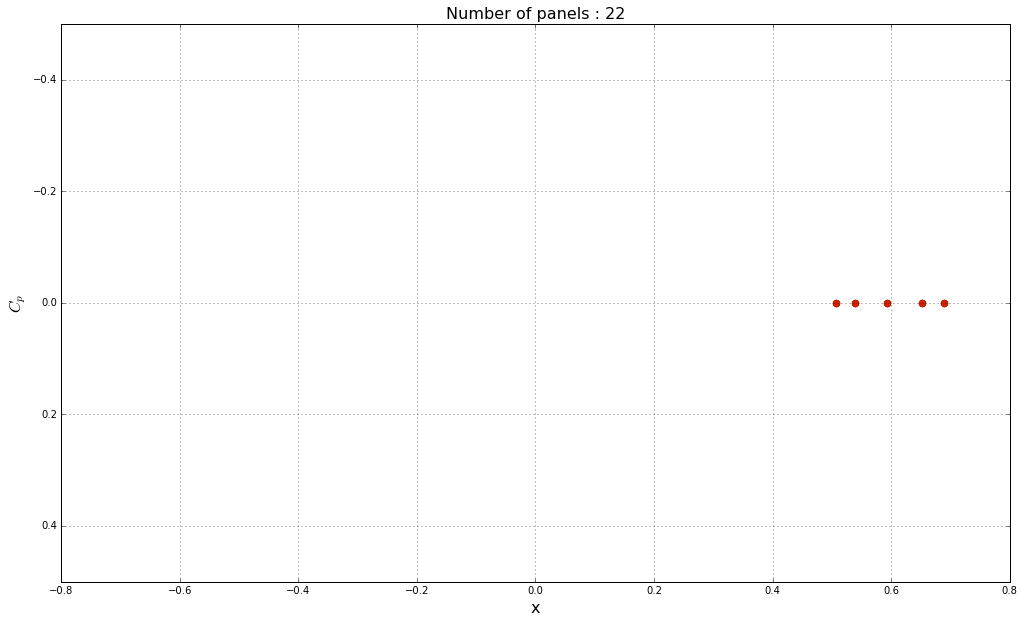

In [23]:
# plots the surface pressure coefficient
pyplot.figure(figsize=(17,10))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.scatter([p.xc for p in Nt[0:No]], [p.cp for p in Nt[0:No]], color='#CD2305', s=40, zorder=2)
pyplot.scatter([p.xc for p in Nt[0:No]], [p.cp for p in Nt[0:No]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % No, fontsize=16)
pyplot.xlim(-0.8, 0.8)
pyplot.ylim(-0.5, 0.5);
pyplot.gca().invert_yaxis();